In [65]:

import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform
import datetime
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

In [66]:
sales= pd.read_excel('/content/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx',header =1)
view_rate = pd.read_excel("/content/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx",header =1, index_col= 0)

In [67]:
#2020-01-01 제외
sales=sales[:-9]

In [68]:
def count(t1,t2):
    t1= datetime.datetime.strptime(t1, '%H:%M')
    t2= datetime.datetime.strptime(t2, '%H:%M')
    if(int(str(t2-t1).split(':')[0][-1])>0):
      c=60
    else:
      c=int(str(t2-t1).split(':')[1])
    return c-1

In [69]:
vr = list(sales['방송일시'])

#방송일시 type Timestamp -> 문자열로 처리
for i in range(len(vr)):
  vr[i] = str(vr[i]).replace('Timestamp(','').replace(')','').strip()

In [70]:
#방송일시에서 날짜와 시간대를 분리하여 시간대 평균 시청률 매칭하기
for i in range(len(vr)):
  date = vr[i].split(' ')[0]

  if(i<len(vr)-4): #19-12-31 23:40분 제외
    t1 = vr[i].split(' ')[1][:5] #시간
    #다음 방영 시간대 계산
    def next(t1):
      j=i
      t2 = vr[j+1].split(' ')[1][:5]
      while(t1==t2):
        j=j+1
        t2=vr[j+1].split(' ')[1][:5]
      return vr[j+1].split(' ')[1][:5] #다음 시간
    t2 = next(t1) 
 
  # 만약 다음 시간이 10분이면 
    if(t2[3:]=='10'): 
      time = t1[:3]+'09'
      vr[i]= view_rate[date].rolling(window=count(t1,t2)).mean()[time]
    elif(t1=='01:30'):
      vr[i]= view_rate[date].rolling(window=30).mean()['01:59']
    elif(t1=='01:40'):
      vr[i]= view_rate[date].rolling(window=20).mean()['01:59']
    elif(t1=='01:50'):
      vr[i]= view_rate[date].rolling(window=10).mean()['01:59']
  # 10분 아니면  
    else:
      hour=t1[:3] #시
      min= int(t1[3:])+count(t1,t2) 
      if(min>60): #만약 60분보다 큰 수가 나오면
        min=min-60 # 빼버리고
        if(min<10): #뺀 값이 한자리수 일 때
          min='0'+str(min)   
        new=int(hour[:2])+1# 시간은 +1
        
        if (new<10):
          new='0'+str(new)

        elif(new==24):  
          new='00'
        
        hour=str(new)+':'
      
      time = hour+str(min)
      
      vr[i]= view_rate[date].rolling(window=count(t1,t2)).mean()[time]
  
#12월 31일 11시 40분 처리
  else:
      vr[i]= view_rate[date].rolling(window=20).mean()[vr[i].split(' ')[1][:3]+'59']
     

In [71]:
sales['시청률'] = vr

In [72]:
# 무형 지우기
sales.drop(sales[sales["상품군"]=="무형"].index, inplace=True)

In [73]:
# 결측된 노출분 채우기
for i,row in sales.iterrows():
    val = row["노출(분)"]
    if i == 0 :
        continue
        
    if  np.isnan(val):
        if sales.loc[i,"방송일시"] == sales.loc[i-1,"방송일시"]:
            sales.loc[i,"노출(분)"] = sales.loc[i-1,"노출(분)"]
        else : 
            continue
            
sales.isnull().sum()


방송일시     0
노출(분)    0
마더코드     0
상품코드     0
상품명      0
상품군      0
판매단가     0
취급액      0
시청률      0
dtype: int64

In [74]:

# 판매단가 > 취급액 이면 취급액 = 0 

def custom(price, total):
    if price > total:
        return 0
    
    else:
        return total

sales["취급액"] = sales.apply(lambda x : custom(x["판매단가"], x["취급액"]), axis=1)

# 확인
print(sum((sales["판매단가"] > sales["취급액"]) & (sales['취급액'] != 0)))


0


In [75]:

# month, day, hour, minute, weekday 열 추가
sales['month'] = pd.DatetimeIndex(sales['방송일시']).month
sales['day'] = pd.DatetimeIndex(sales['방송일시']).day
sales['hour'] = pd.DatetimeIndex(sales['방송일시']).hour
sales['minute'] = pd.DatetimeIndex(sales['방송일시']).minute
sales['weekday'] = pd.DatetimeIndex(sales['방송일시']).weekday


In [76]:
sales['시청률'].value_counts(normalize=True)

0.000000e+00    0.168700
3.652049e-19    0.008858
7.304099e-19    0.005539
1.826025e-19    0.004442
1.460820e-18    0.004121
                  ...   
8.888889e-04    0.000027
2.526316e-03    0.000027
2.631579e-03    0.000027
5.555556e-04    0.000027
1.789474e-03    0.000027
Name: 시청률, Length: 9397, dtype: float64

In [77]:
from sklearn.model_selection import train_test_split
x = sales[['노출(분)', '시청률']]
y = sales[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)


In [78]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
y_predicted = model.predict(x_test)

In [80]:
print(model.intercept_)
print(model.coef_[[0]])

[17092178.73951696]
[[1.95549171e+05 1.70261238e+08]]


In [81]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,7.474000e+03
mean,8.033338e+04
std,2.015096e+07
min,-3.066212e+07
25%,-1.479543e+07
50%,-5.489877e+06
75%,1.005279e+07
max,2.107858e+08


In [82]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.005544
dtype: float64


In [83]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)
#오차가...

score =  0.0056759250078922685
Mean_Squared_Error =  406013410403817.94
RMSE =  20149774.450445294


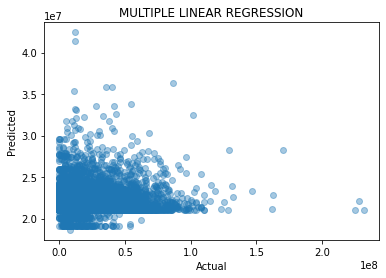

In [84]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [85]:
x_test['노출(분)'].size

7474

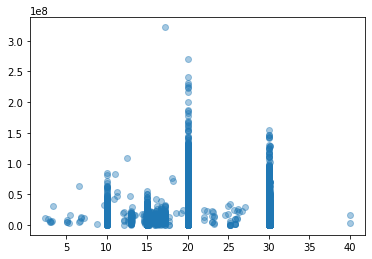

In [86]:
plt.scatter(sales['노출(분)'], sales['취급액'], alpha=0.4)
plt.show()

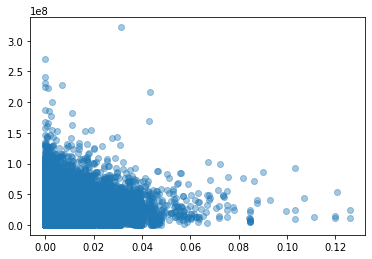

In [87]:
plt.scatter(sales['시청률'], sales['취급액'], alpha=0.4)
plt.show()

In [88]:
sales['취급액'].describe()

count    3.736800e+04
mean     2.186696e+07
std      2.018984e+07
min      0.000000e+00
25%      6.880000e+06
50%      1.612850e+07
75%      3.162475e+07
max      3.220090e+08
Name: 취급액, dtype: float64

In [89]:
sales['노출(분)'].describe()

count    37368.000000
mean        20.384069
std          3.122025
min          2.466667
25%         20.000000
50%         20.000000
75%         20.000000
max         40.000000
Name: 노출(분), dtype: float64

In [90]:
sales['시청률'].describe()

count    3.736800e+04
mean     4.537890e-03
std      8.181684e-03
min      0.000000e+00
25%      3.652049e-18
50%      1.315789e-03
75%      5.157895e-03
max      1.259474e-01
Name: 시청률, dtype: float64

**시청률 높은 애들 대상으로...?**

In [91]:
vr_high =sales[sales['시청률']>=5.157895e-03]

In [92]:
from sklearn.model_selection import train_test_split
x = vr_high[['노출(분)', '시청률']]
y = vr_high[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
y_predicted = model.predict(x_test)

In [94]:
print(model.intercept_)
print('노출시간, 시청률 : ', model.coef_[[0]])

[20882362.00527507]
노출시간, 시청률 :  [[  102014.69652529 75828382.39389929]]


In [95]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,1.861000e+03
mean,4.045479e+05
std,2.250345e+07
min,-2.687135e+07
25%,-1.630235e+07
50%,-5.249698e+06
75%,1.094074e+07
max,2.047333e+08


In [96]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.002327
dtype: float64


In [97]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)


score =  0.0018966043024239987
Mean_Squared_Error =  506296705961482.56
RMSE =  22501037.886317212


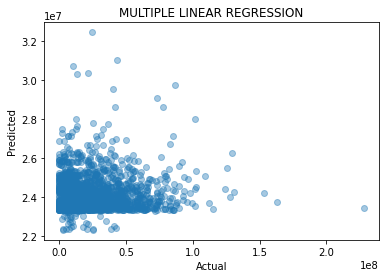

In [98]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

**노출시간 높은 애들 대상으로..?**

In [123]:
vt_high =sales[sales['노출(분)']>=30]

In [116]:
from sklearn.model_selection import train_test_split
x = vt_high[['노출(분)', '시청률']]
y = vt_high[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [124]:
y_predicted = model.predict(x_test)

In [125]:
print(model.intercept_)
print('노출시간, 시청률 : ', model.coef_[[0]])

[1.45489631e+08]
노출시간, 시청률 :  [[-4137936.75724962 49244867.3183258 ]]


In [126]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,5.260000e+02
mean,-2.413549e+05
std,2.328971e+07
min,-2.326698e+07
25%,-1.713153e+07
50%,-9.217528e+06
75%,1.028034e+07
max,1.253500e+08


In [127]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.003724
dtype: float64


In [128]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)


score =  0.003555027901740005
Mean_Squared_Error =  541437805419853.06
RMSE =  23268816.1585383


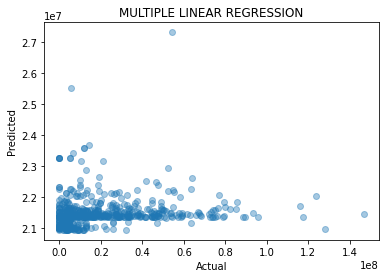

In [129]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

**다항 회귀**

In [130]:
vr_high_poly =vr_high

In [131]:
from sklearn.model_selection import train_test_split
x = vr_high_poly[['시청률']]
y = vr_high_poly[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)


In [132]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X = poly_features.fit_transform(x)
X_poly_train = poly_features.fit_transform(x_train)
X_poly_test = poly_features.fit_transform(x_test)

In [133]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [134]:
y_predicted = model.predict(X_poly_test)

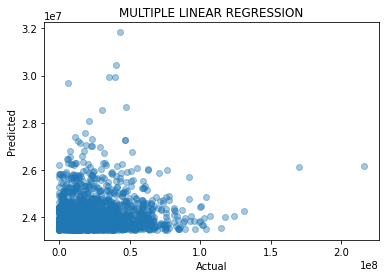

In [135]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [136]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,1.861000e+03
mean,2.366687e+05
std,2.152612e+07
min,-2.620261e+07
25%,-1.604564e+07
50%,-5.505842e+06
75%,1.071121e+07
max,1.898869e+08


In [137]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = X, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)

score =  0.0016714651037895711
Mean_Squared_Error =  463180886894424.3
RMSE =  21521637.644343525
